In [1]:
import csv
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from consul.agent_types.rl_agent import RLAgent
from consul.agent_types.cbr_agent import CaseBased_RLAgent
from war_reason import *
from war_reason_implementations import *

# Load the data

In [2]:
data = pd.read_pickle("FullData.pickle")

In [5]:
# The Game-Theoretic Equilibrium
equilibrium_cols = ['eqTsq', 'eqTnego', 'eqTacqa', 'eqTacqb', 'eqTcapa', 'eqTcapb', 
                'eqTwara', 'eqTwarb']

data["Equilibrium"] = ""
for col in equilibrium_cols:
    data.loc[data[col] == 1, "Equilibrium"] = col

# Cutting out missing data
data = data[data.Equilibrium!=""]

In [6]:
# Observed outcomes
data["Outcome"] = ""

data.loc[((data.cwhost1<2) & (data.cwhost2<2)), "Outcome"] = "StatusQuo"
data.loc[((data.cwhost1>3) & (data.cwhost2>3)), "Outcome"] = "War"
data.loc[((data.cwhost1==data.cwhost2) & (data.cwhost1>1) & 
          (data.cwhost1<4)), "Outcome"] = "Negotiation"
data.loc[((data.cwhost1>data.cwhost2) & (data.cwhost1>1) & 
          (data.cwhost1<4)), "Outcome"] = "Acquiesce_B"
data.loc[((data.cwhost1<data.cwhost2) & (data.cwhost2>1) & 
          (data.cwhost2<4)), "Outcome"] = "Acquiesce_A"
data.loc[((data.cwhost1>data.cwhost2) & (data.cwhost1>3)), "Outcome"] = "Capitulate_B"
data.loc[((data.cwhost1<data.cwhost2) & (data.cwhost2>3)), "Outcome"] = "Capitulate_A"

In [7]:
# OPTIONAL
## Boost all utilities by a fixed factor
for col in data.columns:
    if col[:4] == "wrTu":
        data[col] *= 8

## Fit the RL Model

In [8]:
eugene_world = EUGeneWorld(RLAgent, data, 
                           agent_args={"learning_rate": 0.1, "discount_factor": 0.9},
                           copy_data=True, shuffle_rows=True)

In [9]:
eugene_world.run(model_assessors={"Model_Outcome": lambda m: m.current_node,
                                  "Move_Quality": assess_moves})

0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000


In [10]:
data = eugene_world.eugene_data

In [11]:
outcome_matching = {
    "eqTacqa": ["Acquiesce_A"],
    "eqTacqb": ["Acquiesce_B"],
    "eqTnego": ["Negotiate_1", "Negotiate_2"],
    "eqTsq": ["StatusQuo"],
    "eqTwara": ["War_A1", "War_A2"],
    "eqTwarb": ["War_B1", "War_B2"]}

data["Outcome_Check"] = 0
for key, vals in outcome_matching.items():
    data.loc[((data.Equilibrium==key) & 
                   (data.Model_Outcome.isin(vals))), "Outcome_Check"] = 1

outcome_check = data.Outcome_Check
#plt.plot(pd.rolling_mean(outcome_check, 1000))

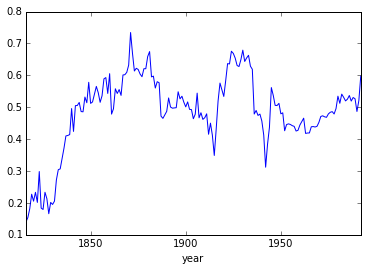

In [12]:
mean_outcome = data.groupby("year").aggregate("mean")["Outcome_Check"]
mean_outcome.plot()

In [13]:
data.Model_Outcome.value_counts()

Negotiate_2      885675
War_A1            42131
Acquiesce_B       33797
Acquiesce_A       26372
War_B2            16350
StatusQuo          7197
War_B1             6512
Capitulate_B1      2991
Capitulate_A2      2002
Negotiate_1        1673
Capitulate_A1      1367
War_A2             1253
Capitulate_B2       372
dtype: int64

In [14]:
data.head()

,ccode1,ccode2,year,euwtT1v2,wrTu1v1,wrTu1v2,wrTu1vsq,wrTp1win,wrTstk1,wrTu1sq,...,cwhost1,cwhost2,cwkeynum,cwhiact1,cwhiact2,Equilibrium,Outcome,Model_Outcome,Move_Quality,Outcome_Check
0,2,200,1816,-1.776549,9.049392,-11.606656,-1.904096,0.048503,2.582006,-1.904096,...,0,0,0,0,0,eqTacqa,StatusQuo,StatusQuo,0.50,0
1,2,210,1816,-1.130330,8.200192,-10.947488,-1.904096,0.107475,2.393460,-1.904096,...,0,0,0,0,0,eqTacqa,StatusQuo,Acquiesce_A,1.00,1
2,2,220,1816,-2.420352,7.401584,-10.311800,-1.904096,0.071763,2.214174,-1.904096,...,0,0,0,0,0,eqTacqa,StatusQuo,War_B1,0.80,0
3,2,225,1816,-0.156504,7.196240,-10.145960,-1.904096,0.118632,2.167775,-1.904096,...,0,0,0,0,0,eqTacqa,StatusQuo,Negotiate_2,0.25,0
4,2,230,1816,-1.166779,8.200192,-10.947488,-1.904096,0.111646,2.393460,-1.904096,...,4,1,3239,16,0,eqTacqa,Capitulate_B,Acquiesce_B,0.00,0


# Run several iterations of a model

In [15]:
fitted_data = []
save_cols = ["year", "ccode1", "ccode2", "Equilibrium", "Outcome", "Model_Outcome"]

for i in range(2):
    eugene_world = EUGeneWorld(RLAgent, data, 
                           agent_args={"learning_rate": 0.1, "discount_factor": 0.9},
                           copy_data=True, shuffle_rows=True)
    eugene_world.run(report_every=2000000,
        model_assessors={"Model_Outcome": lambda m: m.current_node})
    next_data = eugene_world.eugene_data.loc[:,save_cols]
    next_data["Iteration"] = i
    fitted_data.append(next_data)
    print(i)

0
0
0
1


In [16]:
data = pd.concat(fitted_data)

In [19]:
data.Iteration.unique()

array([0, 1])

In [ ]:
outcome_matching = {
    "eqTacqa": ["Acquiesce_A"],
    "eqTacqb": ["Acquiesce_B"],
    "eqTnego": ["Negotiate_1", "Negotiate_2"],
    "eqTsq": ["StatusQuo"],
    "eqTwara": ["War_A1", "War_A2"],
    "eqTwarb": ["War_B1", "War_B2"]}

data["Outcome_Check"] = 0
for key, vals in outcome_matching.items():
    data.loc[((data.Equilibrium==key) & 
                   (data.Model_Outcome.isin(vals))), "Outcome_Check"] = 1

In [ ]:
for group in data.groupby("Iteration"):
    mean_outcome = group[1].groupby("year").aggregate("mean")["Outcome_Check"]
    mean_outcome.plot()

## Does the model prediction predict the actual outcome?

In [ ]:
data = data[(data.cwhost1!=-9) & (data.cwhost2!=-9)]

In [ ]:
model_dummies = pd.get_dummies(data.Model_Outcome)

In [ ]:
model_dummies.columns

In [ ]:
model_dummies["Negotiate"] = (model_dummies.Negotiate_1 + 
                                    model_dummies.Negotiate_2)

model_dummies["War"] = (model_dummies.War_A1 + model_dummies.War_A2 + 
                        model_dummies.War_B1 + model_dummies.War_B2)

In [ ]:
model_dummies["Const."] = 1

In [ ]:
data.Outcome.value_counts()

In [ ]:
data["Acquiesce_A"] = 0
data.loc[data.Outcome=="Acquiesce_A", "Acquiesce_A"] = 1
data["Negotiation"] = 0
data.loc[data.Outcome=="Negotiation", "Negotiation"] = 1
data["War"] = 0
data.loc[data.Outcome=="War", "War"] = 1


In [ ]:
import statsmodels.api as sm

In [ ]:
x_cols = ["Acquiesce_A", "Acquiesce_B", "Negotiate", "War", "Const."]
logit = sm.Logit(data.Acquiesce_A, model_dummies[x_cols])
#logit = sm.Logit(data.Negotiation, model_dummies[x_cols])
result = logit.fit()
print(result.summary())

In [ ]:
x_cols = ["Acquiesce_A", "Acquiesce_B", "Negotiate", "War", "Const."]
logit = sm.Logit(data.Negotiation, model_dummies[x_cols])
#logit = sm.Logit(data.Negotiation, model_dummies[x_cols])
result = logit.fit()
print(result.summary())

In [ ]:
x_cols = ["Acquiesce_A", "Acquiesce_B", "Negotiate", "War", "Const."]
logit = sm.Logit(data.War, model_dummies[x_cols])
result = logit.fit()
print(result.summary())

### Only a subset of the data

In [ ]:
START = 1980
subset = data[data.year>START]
dummies_subset = model_dummies[data.year>START]

In [ ]:
x_cols = ["Acquiesce_A", "Acquiesce_B", "Negotiate", "War", "Const."]
logit = sm.Logit(subset.Acquiesce_A, dummies_subset[x_cols])
result = logit.fit()
print(result.summary())

In [ ]:
x_cols = ["Acquiesce_A", "Acquiesce_B", "Negotiate", "War", "Const."]
logit = sm.Logit(subset.War, dummies_subset[x_cols])
result = logit.fit()
print(result.summary())